# Conformer generation for small molecules

## Background ##
### Algorithm ###

Given a list of $N$ dihedral angles (torsions) `dihedrals`

1. generate all conformers by rotating all torsions in increments $\delta\phi$ for a total of $(2\pi/\delta\phi)^N$ conformers (cartesian product)
2. write to a trajectory

### Implementation notes ###

1. Load molecules with MDAnalysis.
2. Convert to RDKit molecule.
3. Perform torsion drive with [rdkit.Chem.rdMolTransforms](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolTransforms.html)

```
rdkit.Chem.rdMolTransforms.SetDihedralDeg((Conformer)arg1, (int)arg2, (int)arg3, (int)arg4, (int)arg5, (float)arg6) → None :

    Sets the dihedral angle in degrees between atoms i, j, k, l; all atoms bonded to atom l are moved
```

### Initial test data ###
#### COW dataset ####

`/Users/oliver/Projects/Methods/SAMPL5/sampl5-distribution-water-cyclohexane/11_validation_dataset92`

- V36-methylacetate : 1 dihedral
- V46-2-methyl-1-nitrobenzene : steric hindrance
- V39-butylacetate : 4 dihedrals


## Setup
### Packages

The packages do not need to be explictly imported because `confgen` does all importing. However, it's still useful to make sure that these packages are available:

In [1]:
import MDAnalysis as mda
import rdkit
import rdkit.Chem.rdMolTransforms
from rdkit.Chem.rdMolTransforms import SetDihedralDeg
import numpy as np

import itertools

In [2]:
print(mda.__version__)
print(rdkit.__version__)

2.5.0
2023.03.2


Nicer RDKit output in the notebook (larger labels)

In [3]:
import rdkit.Chem.Draw.IPythonConsole
rdkit.Chem.Draw.IPythonConsole.drawOptions.annotationFontScale = 0.8

### Data paths

Functions work with `pathlib.Path` instances:

In [4]:
import pathlib

In [5]:
COWDIR = pathlib.Path("./COW")
DATADIRS = {p.name[:3]: p for p in COWDIR.glob("V[0-9][0-9]-*")}

In [6]:
DATADIRS

{'V39': PosixPath('COW/V39-butylacetate'),
 'V36': PosixPath('COW/V36-methylacetate'),
 'V46': PosixPath('COW/V46-2-methyl-1-nitrobenzene')}

## Using `molconfgen`

Production code is stored in the `molconfgen` package (subject to name change...).

At the moment, the package is not installable so just add its location to the path:

In [7]:
import sys
sys.path.append("..")

In [8]:
import molconfgen
from molconfgen import sampler, chem

During development it is useful to be reload the packages with edits.

In [9]:
# during development
from importlib import reload
reload(sampler)
reload(chem)

<module 'molconfgen.chem' from '/Volumes/ASU/oliver/Projects/Methods/smallmol_conformers/notebooks/../molconfgen/chem.py'>

### Sampling with custom dihedrals

We will use the MDPOW input files for V36 and generate a trajectory that samples two torsions that we select explicitly ourselves.

In [10]:
d = DATADIRS['V36']
d

PosixPath('COW/V36-methylacetate')

Use the convenience function `load_mdpow_mol()` (otherwise, use `load_mol(universe)`):

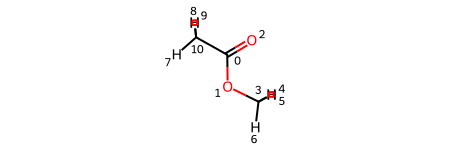

In [11]:
u, mol = chem.load_mdpow_mol(d, add_labels=True)
mol

Set up dihedrals as MDAnalysis dihedral objects.

In [12]:
dihedrals = [u.atoms[[7, 10, 0, 1]].dihedral,
             u.atoms[[10, 0, 1, 3]].dihedral]

Run the sampler; this is very fast but note that the size of the in-memory trajectory grows exponentially with increasing samples and dihedrals.

In [13]:
samples = sampler.generate_conformers(mol, dihedrals, num=36)

  0%|          | 0/1296 [00:00<?, ?it/s]

The resulting `samples` universe can now be analyzed or we can just write the conformers to a trajectory in any format that MDAnalysis can write:

In [14]:
samples.atoms.write("conformers.trr", frames="all")

### Sampling with automatically extracted dihedrals

#### single dihedral (V36)
Here we show the process, step by step:

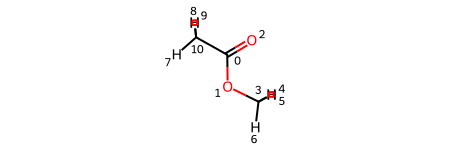

In [15]:
molid = "V36"
u, mol = chem.load_mdpow_mol(DATADIRS[molid], add_labels=True)
mol

Step-by-step process:
1. use RDKIT for getting dihedral indices
2. index the MDAnalysis atoms to get dihedrals

In [16]:
dh_ix = chem.find_dihedral_indices(mol)
dihedrals = [u.atoms[indices].dihedral for indices in dh_ix]
dihedrals

[<Dihedral between: Atom 2, Atom 0, Atom 1, Atom 3>]

Run the sampler:

In [17]:
conformers = sampler.generate_conformers(mol, dihedrals)

  0%|          | 0/12 [00:00<?, ?it/s]

Write trajectory for downstream processing:

In [18]:
conformers.atoms.write(f"{molid}_conformers.trr", frames="all")

#### multiple dihedrals (V39)

Combining multiple steps and making use of higher level functions:

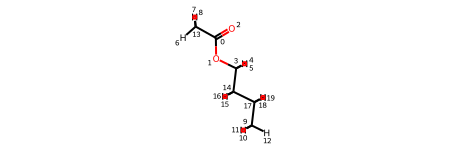

In [19]:
molid = "V39"
u, mol = chem.load_mdpow_mol(DATADIRS[molid], add_labels=True)
mol

In [20]:
dihedrals = chem.find_dihedrals(mol, u)
print(dihedrals)

conformers = sampler.generate_conformers(mol, dihedrals)
conformers.atoms.write(f"{molid}_conformers.trr", frames="all")

[<Dihedral between: Atom 2, Atom 0, Atom 1, Atom 3>, <Dihedral between: Atom 0, Atom 1, Atom 3, Atom 14>, <Dihedral between: Atom 1, Atom 3, Atom 14, Atom 17>, <Dihedral between: Atom 3, Atom 14, Atom 17, Atom 9>]


  0%|          | 0/20736 [00:00<?, ?it/s]

#### Complete example (V46)
Run everything in one go with a convenience function:

In [21]:
def run_sampler(molid, num=12):
    topdir = DATADIRS[molid]
    u, mol = chem.load_mdpow_mol(topdir, add_labels=True)
    dihedrals = chem.find_dihedrals(mol, u)

    conformers = sampler.generate_conformers(mol, dihedrals, num=num)
    filename = f"{molid}_conformers.trr"
    conformers.atoms.write(filename, frames="all")

    return u, mol, dihedrals, filename

  0%|          | 0/36 [00:00<?, ?it/s]

[<Dihedral between: Atom 2, Atom 1, Atom 0, Atom 4>]
V46_conformers.trr


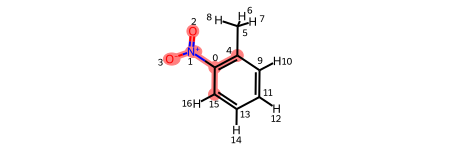

In [22]:
u, mol, dihedrals, filename = run_sampler("V46", num=36)
print(dihedrals)
print(filename)
mol